# AIT Deep Learning Pedestrian Detection Project
Note: We used GitHub Copilot to generate some of the code, such as displaying images using matplotlib.

References: 
- https://keras.io/examples/vision/yolov8/
- https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/
- https://keras.io/guides/keras_cv/object_detection_keras_cv/

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import json
import random

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras_cv import bounding_box, visualization
from keras_cv.losses import CIoULoss
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard

2024-05-14 06:22:15.087243: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 06:22:15.111724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 06:22:15.111746: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 06:22:15.111750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 06:22:15.115380: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


/home/lehoangchibach/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We are running this program on Bach's computer that has GPU.

In [3]:
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],
)
logical_gpus = tf.config.list_logical_devices("GPU")
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


2024-05-14 06:22:17.229694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 06:22:17.245685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 06:22:17.245906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 1-1 Processing the image and annotation
The Pedestrian dataset contains train and validation data. We are using the train data for training and validation, and validation data for testing. Images are stored in `images/{train/val}/{image_id}.jpg`, and annotations are stored in `annotations/dhd_pedestrian_traffic_{train/val}.json`.

In [4]:
SPLIT_RATIO = 0.8
BATCH_SIZE = 13
LEARNING_RATE = 0.01
GLOBAL_CLIPNORM = 10.0

class_mapping = {
    0: "pedestrian"
}  # We only have one class for our bounding box, pedestrian.

In [5]:
""" Returns bounding boxes for every image
"""


def convert_annotations(img_type: str) -> (int, dict):
    with open(f"annotations/dhd_pedestrian_traffic_{img_type}.json") as f:
        annotations = json.load(f)

    boxes = {}
    image_ids = []
    for anno in annotations["annotations"]:
        image_id = anno["image_id"]

        if image_id not in image_ids:
            image_ids.append(image_id)

        if image_id not in boxes:
            boxes[image_id] = {}
            boxes[image_id]["image_path"] = f"images/{img_type}/{image_id}.jpg"
            boxes[image_id]["boxes"] = []
            boxes[image_id]["class_ids"] = []
        boxes[image_id]["boxes"].append(anno["bbox"])
        boxes[image_id]["class_ids"].append(0)

    return image_ids, boxes

In [6]:
""" Load image into uint8 tensor
"""


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


""" Load image and bounding_boxes pair
"""


def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

We are using data augmenter to generate diverse training dataset that does not have to be loaded to the memory at once. For phase 2, we are using random holizontal flip and resizing.

In [7]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

2024-05-14 02:37:44.685783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 7.81GiB (8388608000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [8]:
def create_raw_dataset(image_ids, annos):
    image_paths = []
    boxes = []
    class_ids = []

    set_images_ids = set(image_ids)
    for i in annos:
        if i not in set_images_ids:
            continue

        x = annos[i]
        image_paths.append(x["image_path"])
        boxes.append(x["boxes"])
        class_ids.append(x["class_ids"])

    bbox = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(class_ids)
    image_paths = tf.ragged.constant(image_paths)

    return tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))


def process_train_valid():
    image_ids, annos = convert_annotations("train")

    slice_index = int(len(image_ids) * SPLIT_RATIO)
    train_image_ids = image_ids[:slice_index]
    valid_image_ids = image_ids[slice_index:]

    train_image_ids = random.choices(train_image_ids, k=500)
    valid_image_ids = random.choices(valid_image_ids, k=50)

    train_data = create_raw_dataset(train_image_ids, annos)
    valid_data = create_raw_dataset(train_image_ids, annos)

    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 4)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

    valid_ds = valid_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    # valid_ds = valid_ds.shuffle(BATCH_SIZE * 4)
    valid_ds = valid_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    valid_ds = valid_ds.map(
        keras_cv.layers.Resizing(
            640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    return train_ds, valid_ds

In [9]:
train_ds, valid_ds = process_train_valid()

### 1-2 Visualizing the Dataset

In [10]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

#### Augmented Training images

In [11]:
# visualize_dataset(
#     train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
# )

#### Validation images

In [12]:
# visualize_dataset(
#     valid_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
# )

## 2 Building and training the model

### 2-1 Model Creation

In [13]:
# We are converting dictionary to tuple as tensorflow needs to have tuple of each element.
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

In [14]:
K.clear_session()
print(gc.collect())


backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    # "yolo_v8_s_backbone_coco"  # We will use backend yolov8 small backbone with coco weights
    "yolo_v8_xs_backbone_coco"
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
)

optimizer = tf.keras.optimizers.SGD(global_clipnorm=GLOBAL_CLIPNORM)

yolo.compile(
    optimizer=optimizer,
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    jit_compile=False,
)

1924


/home/lehoangchibach/anaconda3/envs/gpu11_cv/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/lehoangchibach/anaconda3/envs/gpu11_cv/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [15]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        # K.clear_session()


clear_mem = ClearMemory()
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_box_loss",
    patience=15,
    min_delta=0.005,
    restore_best_weights=True,
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_box_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)


# coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
#     valid_ds, bounding_box_format="xywh"
# )

checkpoint_filepath = "weights_epoch-{epoch:02d}.hdf5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_box_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)


log_dir = "runs/fully_trained_yolov8xs"
tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq="epoch")

### 2-2 Training

In [ ]:
%%time
network_history = yolo.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=700,
    callbacks=[
        es,
        clear_mem,
        # coco_metrics_callback,
        lr_scheduler,
        tensorboard_callback,
        model_checkpoint_callback,
    ],
    verbose=2,
)

Epoch 1/700


2024-05-14 02:38:15.743698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-14 02:38:26.377009: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x719ec7689620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 02:38:26.377026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-14 02:38:26.402070: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_box_loss improved from inf to 5.42708, saving model to weights_epoch-01.hdf5
37/37 - 58s - loss: 804.4628 - box_loss: 4.4014 - class_loss: 800.0616 - val_loss: 755.7694 - val_box_loss: 5.4271 - val_class_loss: 750.3420 - lr: 0.0100 - 58s/epoch - 2s/step
Epoch 2/700

Epoch 2: val_box_loss improved from 5.42708 to 5.39127, saving model to weights_epoch-02.hdf5
37/37 - 38s - loss: 166.5930 - box_loss: 4.7158 - class_loss: 161.8773 - val_loss: 241.2774 - val_box_loss: 5.3913 - val_class_loss: 235.8861 - lr: 0.0100 - 38s/epoch - 1s/step
Epoch 3/700

Epoch 3: val_box_loss improved from 5.39127 to 5.07159, saving model to weights_epoch-03.hdf5
37/37 - 36s - loss: 40.4141 - box_loss: 4.4648 - class_loss: 35.9493 - val_loss: 55.4838 - val_box_loss: 5.0716 - val_class_loss: 50.4122 - lr: 0.0100 - 36s/epoch - 975ms/step
Epoch 4/700

Epoch 4: val_box_loss improved from 5.07159 to 3.94733, saving model to weights_epoch-04.hdf5
37/37 - 37s - loss: 13.4834 - box_loss: 3.6759 - class_los

In [ ]:
# yolo.save("./models/fully_trained_yolov8xs.keras")

### 2-3 Model Evaluation

In [ ]:
def plot_history(network_history, x):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Box_loss")
    plt.plot(network_history.history["box_loss"][x:])
    plt.plot(network_history.history["val_box_loss"][x:])
    plt.legend(["Training", "Validation"])


plot_history(network_history, 3)

In [7]:
## No augumentation for the test dataset
def process_test():
    image_ids, annos = convert_annotations("val")

    image_paths = []
    boxes = []
    class_ids = []
    for i in image_ids:
        x = annos[i]
        image_paths.append(x["image_path"])
        boxes.append(x["boxes"])
        class_ids.append(x["class_ids"])

    bbox = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(class_ids)
    image_paths = tf.ragged.constant(image_paths)

    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

    ds = data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(BATCH_SIZE * 4)
    ds = ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.map(
        keras_cv.layers.Resizing(
            640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds

In [20]:
yolo = keras.models.load_model('./models/fully_trained_yolov8xs.keras')
optimizer = tf.keras.optimizers.SGD(global_clipnorm=GLOBAL_CLIPNORM)
# yolo.load_weights('./weights/best_weights.hdf5')
yolo.compile(
    optimizer=optimizer,
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    jit_compile=False,
)

In [22]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )
    
yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.7,
)

test_ds = process_test()
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

result = yolo.evaluate(test_ds, return_dict=True)
print(result)

164/164 [==============================] - 37s 205ms/step - loss: 3.3488 - box_loss: 2.0693 - class_loss: 1.2795
{'loss': 3.348828077316284, 'box_loss': 2.069340705871582, 'class_loss': 1.2794872522354126}


### 2-4 Prediction

1/1 [==============================] - 1s 1s/step


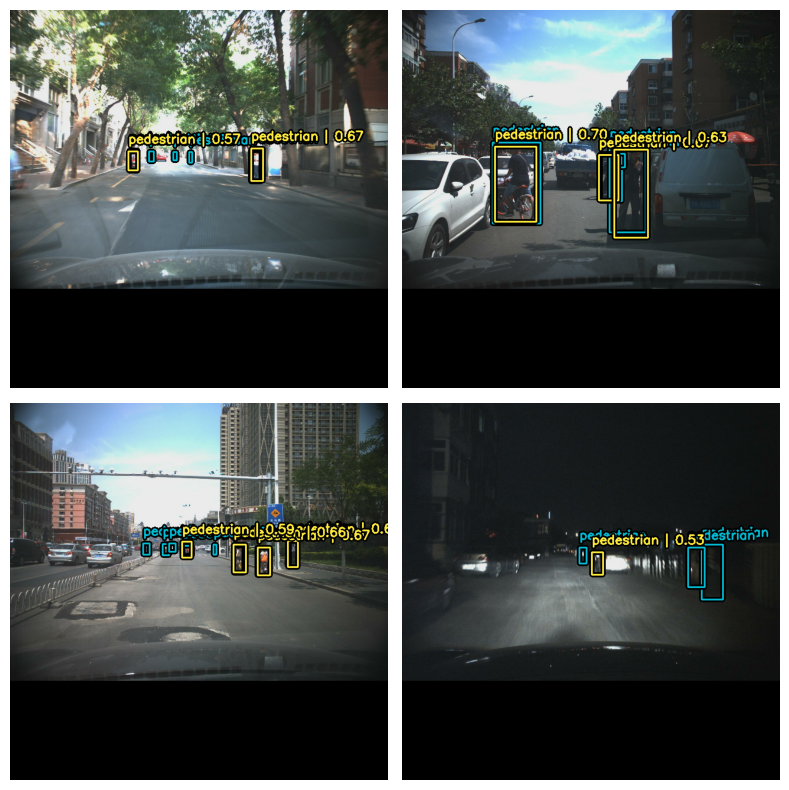

In [25]:
# Reference: https://keras.io/guides/keras_cv/object_detection_keras_cv/#training-our-model example
yolo.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    confidence_threshold=0.53,  # This is the thing to tune. Higher means fewer boxes are predicted.
    iou_threshold=0.5,
    max_detections=100,
    max_detections_per_class=25,
)
image, bbox = next(iter(test_ds))
y_pred = yolo.predict(image)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=bbox,
    y_pred=y_pred,
    scale=4,
    rows=2,
    cols=2,
    show=True,
    font_scale=0.7,
    class_mapping=class_mapping,
)

In [ ]:
gc.collect()
K.clear_session()